In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,WordCount,Normalized Text,Tokenized Text,Text_No_Stop_Words,Lemmatized Text
0,0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,48,i have bought several of the vitality canned d...,"['i', 'have', 'bought', 'several', 'of', 'the'...","['bought', 'several', 'vitality', 'canned', 'd...","[bought, several, vitality, canned, dog, food,..."
1,1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN,31,product arrived labelled as lumbo halted peanu...,"['product', 'arrived', 'labelled', 'as', 'lumb...","['product', 'arrived', 'labelled', 'lumbo', 'h...","[product, arrived, labelled, lumbo, halted, pe..."
2,2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,94,this is a connection that has been around a fe...,"['this', 'is', 'a', 'connection', 'that', 'has...","['connection', 'around', 'centuries', 'light',...","[connection, around, century, light, pillow, c..."
3,3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0,41,if you are looking for the secret ingredient i...,"['if', 'you', 'are', 'looking', 'for', 'the', ...","['looking', 'secret', 'ingredient', 'robitussi...","[looking, secret, ingredient, robitussin, beli..."
4,4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN,27,great staff at a great price there was a wide...,"['great', 'staff', 'at', 'a', 'great', 'price'...","['great', 'staff', 'great', 'price', 'wide', '...","[great, staff, great, price, wide, assortment,..."


# Classificazione

In [5]:
classification_df = df[['Score', 'Lemmatized Text']]

Text(0, 0.5, 'Number of reviews')

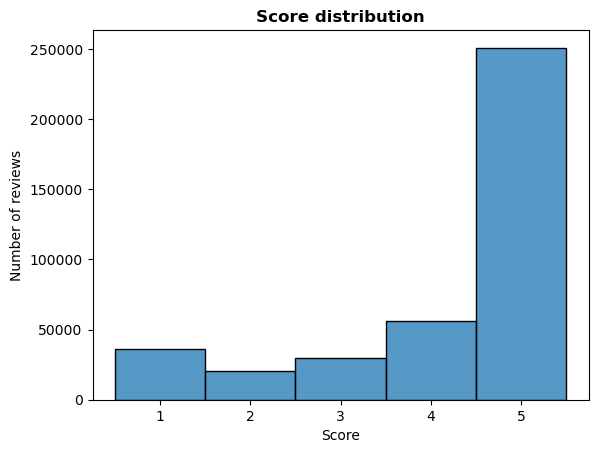

In [6]:
sns.histplot(classification_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [7]:
print(classification_df['Score'].value_counts()/len(classification_df['Score']));

5    0.637067
4    0.142392
1    0.092164
3    0.075570
2    0.052807
Name: Score, dtype: float64


Le classi sono fortemente sbilanciate, con quasi il 78% delle review appartenenti alla classe 4 e 5. E' necessaria una procedura di resampling, in modo tale che i classificatori non diano stime distorte (classificando tutte le review come appartenenti alla classe 5 si otterrebbe comunque il 63% di accuratezza).

In [8]:
# Come sample size prendo il totale delle review appartenenti alla classe meno numerosa

sample_size = classification_df.groupby('Score').count().min()[0]

In [9]:
df_downsampled = classification_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Score,Lemmatized Text
346712,1,"[adopted, rescue, labhow, mix, shelter, said, ..."
233094,1,"[would, never, order, bag, old, disappointing,..."
47395,1,"[nowwhat, water, oh, still, water, sparkling, ..."
84146,1,"[sent, past, due, water, taste, badplease, sen..."
200004,1,"[microwavable, packet, terrible, open, actuall..."
...,...,...
270891,5,"[calorie, per, package, enjoy, watching, weigh..."
332368,5,"[chocolate, incredible, received, bar, gift, i..."
78502,5,"[monthold, twin, boy, arent, big, fan, spinal,..."
207308,5,"[student, love, pity, six, love, giant, one, e..."


Text(0, 0.5, 'Number of reviews')

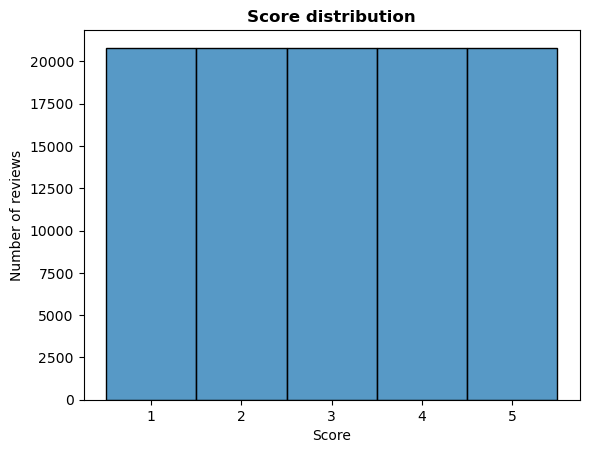

In [10]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [11]:
# Separo train e test

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['Lemmatized Text'], 
                                                    df_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=df_downsampled['Score'])

## BOW

In [33]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(X_train.astype(str)) 
X_train_BOW = cv_model.transform(X_train.astype(str))

In [34]:
X_train_BOW.shape

(72807, 79849)

Devo necessariamente ridurre la dimensionalità della matrice:

In [35]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(X_train_BOW)
X_train_BOW = tSVD_BOW.transform(X_train_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.7998453861151269


In [36]:
# Applico la stessa trasformazione al Test

X_test_BOW = cv_model.transform(X_test.astype(str))
X_test_BOW = SVD_BOW.transform(X_test_BOW)

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- ...

In [37]:
# Regressione logistica

lr_BOW = LogisticRegression(random_state=1)
model_lr_BOW = lr_BOW.fit(X_train_BOW, y_train)
predictions_lr_BOW = model_lr_BOW.predict(X_test_BOW)

In [40]:
# Random Forest

rf_BOW = RandomForestClassifier(n_jobs = -1)
model_rf_BOW = rf_BOW.fit(X_train_BOW, y_train)
predictions_rf_BOW = model_rf_BOW.predict(X_test_BOW)

Analizzo i risultati:

In [33]:
def evaluation(prediction, ground_truth):
  print(confusion_matrix(ground_truth, prediction))
  print(classification_report(ground_truth, prediction))

In [39]:
# Regressione Logistica

evaluation(predictions_lr_BOW, y_test)

[[4013 1150  438  255  385]
 [1746 2172 1269  552  501]
 [ 776 1295 2157 1338  674]
 [ 331  445 1087 2555 1823]
 [ 298  214  302 1076 4351]]
              precision    recall  f1-score   support

           1       0.56      0.64      0.60      6241
           2       0.41      0.35      0.38      6240
           3       0.41      0.35      0.38      6240
           4       0.44      0.41      0.43      6241
           5       0.56      0.70      0.62      6241

    accuracy                           0.49     31203
   macro avg       0.48      0.49      0.48     31203
weighted avg       0.48      0.49      0.48     31203



In [41]:
# Random Forest

evaluation(predictions_rf_BOW, y_test)

[[2957 1295  842  526  621]
 [1779 1604 1336  840  681]
 [1208 1327 1675 1186  844]
 [ 840 1051 1284 1607 1459]
 [ 840  762  759 1128 2752]]
              precision    recall  f1-score   support

           1       0.39      0.47      0.43      6241
           2       0.27      0.26      0.26      6240
           3       0.28      0.27      0.28      6240
           4       0.30      0.26      0.28      6241
           5       0.43      0.44      0.44      6241

    accuracy                           0.34     31203
   macro avg       0.33      0.34      0.34     31203
weighted avg       0.33      0.34      0.34     31203



## TF-IDF

In [47]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(X_train.astype(str))
X_train_TFIDF = tv.transform(X_train.astype(str))

In [43]:
X_train_TFIDF.shape

(72807, 79849)

In [48]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(X_train_TFIDF)
X_train_TFIDF = tSVD_TFIDF.transform(X_train_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5671672897590709


In [49]:
# Applico la stessa trasformazione al Test

X_test_TFIDF = tv_model.transform(X_test.astype(str))
X_test_TFIDF = SVD_TFIDF.transform(X_test_TFIDF)

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- ...

In [50]:
# Regressione logistica

lr_TFIDF = LogisticRegression(random_state=1)
model_lr_TFIDF = lr_TFIDF.fit(X_train_TFIDF, y_train)
predictions_lr_TFIDF = model_lr_TFIDF.predict(X_test_TFIDF)

In [51]:
# Random Forest

rf_TFIDF = RandomForestClassifier(n_jobs = -1)
model_rf_TFIDF = rf_TFIDF.fit(X_train_TFIDF, y_train)
predictions_rf_TFIDF = model_rf_TFIDF.predict(X_test_TFIDF)

Analizzo i risultati:

In [52]:
# Regressione Logistica

evaluation(predictions_lr_TFIDF, y_test)

[[4014 1199  459  224  345]
 [1665 2262 1355  559  399]
 [ 768 1299 2305 1279  589]
 [ 337  447 1171 2658 1628]
 [ 303  224  317 1178 4219]]
              precision    recall  f1-score   support

           1       0.57      0.64      0.60      6241
           2       0.42      0.36      0.39      6240
           3       0.41      0.37      0.39      6240
           4       0.45      0.43      0.44      6241
           5       0.59      0.68      0.63      6241

    accuracy                           0.50     31203
   macro avg       0.49      0.50      0.49     31203
weighted avg       0.49      0.50      0.49     31203



In [53]:
# Random Forest
evaluation(predictions_rf_TFIDF, y_test)

[[3281 1173  705  485  597]
 [1843 1671 1162  876  688]
 [1210 1320 1473 1248  989]
 [ 755  907 1197 1741 1641]
 [ 704  614  698 1287 2938]]
              precision    recall  f1-score   support

           1       0.42      0.53      0.47      6241
           2       0.29      0.27      0.28      6240
           3       0.28      0.24      0.26      6240
           4       0.31      0.28      0.29      6241
           5       0.43      0.47      0.45      6241

    accuracy                           0.36     31203
   macro avg       0.35      0.36      0.35     31203
weighted avg       0.35      0.36      0.35     31203



## W2V Representation

In [37]:
# Creo il modello W2V sul training
w2v_model = gensim.models.Word2Vec(X_train, vector_size=300, window=8, min_count=2)

In [38]:
# Ho a disposizione il modello W2V, che ha convertito ogni parola presente nel training (nello specifico, deve essere presente almeno
# due volte --> min_count=2) in un vettore a 100 componenti. Per generare un vettore rappresentativo di ciascuna review andrò a creare un
# vettore costituito dalla media (componente per componente) dei vettori delle parole appartenenti alla review

# https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

words = set(w2v_model.wv.index_to_key) # Lista di parole presenti nel modello W2V

# Creo due liste, una per il training e una per il test. Ciascuna lista contiene come elementi delle altre liste. Ciascun elemento (ciascuna
# lista) contiene i vettori relativi alle parole di una specifica review (una lista per review contenente i vettori delle singole parole)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

In [39]:
# Per spiegare meglio quanto fatto sopra uso questo esempio:
# La prima review del training è la seguente
X_train.head(1)

233833    [love, walker, shortbread, package, received, ...
Name: Lemmatized Text, dtype: object

In [40]:
# Le prime due parole sono 'love' e 'walker'. Stampo i vettori di queste due parole
w2v_model.wv.get_vector('love')

array([ 4.95740891e-01,  1.42750120e+00, -1.33896142e-01, -6.86041594e-01,
       -7.19485343e-01, -7.93651938e-01,  1.15685356e+00, -6.14115000e-01,
        2.28553593e-01,  2.69004583e-01,  3.25778872e-01,  1.69879794e+00,
        1.41881526e-01,  9.17170584e-01,  3.16702388e-02,  1.46821547e+00,
        4.49912101e-02,  7.17119634e-01,  4.96085614e-01, -5.34303129e-01,
        1.74728072e+00,  3.61289382e-01, -4.08414155e-01,  1.03835714e+00,
       -5.60231566e-01, -6.54482365e-01, -1.42523384e+00,  1.90902576e-01,
       -2.68654495e-01, -1.87229291e-01, -9.01958048e-01, -4.65584874e-01,
        1.17226541e+00, -7.44929492e-01,  3.28890234e-01, -8.13750401e-02,
       -2.11938351e-01,  5.97703993e-01, -1.65513313e+00,  9.86304164e-01,
       -1.33313727e+00,  1.86098146e+00,  7.63971090e-01,  5.04213214e-01,
       -5.33201993e-01, -1.36985973e-01, -2.80312598e-01,  5.64275026e-01,
       -1.07616177e-02, -1.14847159e+00, -2.49031022e-01, -1.27434894e-01,
       -3.89700413e-01, -

In [41]:
w2v_model.wv.get_vector('walker')

array([ 9.42213833e-02,  1.82826459e-01,  6.20155558e-02, -8.69874470e-03,
       -2.92528626e-02,  4.57462892e-02,  3.09792608e-01,  2.87384868e-01,
       -1.54457361e-01, -3.45668644e-02, -1.39221057e-01, -2.19435453e-01,
        3.52876037e-02,  6.52834540e-03, -1.24719001e-01, -1.36476234e-01,
       -4.33594473e-02,  6.41474724e-02,  1.17532879e-01, -1.62117422e-01,
       -2.39990786e-01,  4.64417450e-02, -4.91957217e-02,  5.23619493e-03,
        1.73291847e-01,  1.89893678e-01, -2.64248461e-01, -3.81938592e-02,
       -3.46491933e-02, -1.47764906e-01,  4.78482731e-02, -7.57078528e-02,
        6.05102964e-02, -1.16253085e-01, -1.79632213e-02,  3.15996557e-02,
        9.47123244e-02, -1.31831557e-01, -3.13860476e-02, -7.57221952e-02,
        8.80853385e-02,  9.71878842e-02,  4.02913205e-02, -7.45962933e-02,
        3.59709002e-02,  2.82366395e-01,  1.30130142e-01,  1.98756859e-01,
       -2.78159287e-02,  7.51071796e-02, -3.46867666e-02, -2.99632400e-02,
        3.67706195e-02,  

In [42]:
# Per vedere che sono identici, stampo i primi due elementi della prima lista in X_train_vec. Questi due elementi corrispondono ai vettori
# delle prime due parole della review selezionata, ossia 'love' e 'walker'
X_train_vect[0][0]

array([ 4.95740891e-01,  1.42750120e+00, -1.33896142e-01, -6.86041594e-01,
       -7.19485343e-01, -7.93651938e-01,  1.15685356e+00, -6.14115000e-01,
        2.28553593e-01,  2.69004583e-01,  3.25778872e-01,  1.69879794e+00,
        1.41881526e-01,  9.17170584e-01,  3.16702388e-02,  1.46821547e+00,
        4.49912101e-02,  7.17119634e-01,  4.96085614e-01, -5.34303129e-01,
        1.74728072e+00,  3.61289382e-01, -4.08414155e-01,  1.03835714e+00,
       -5.60231566e-01, -6.54482365e-01, -1.42523384e+00,  1.90902576e-01,
       -2.68654495e-01, -1.87229291e-01, -9.01958048e-01, -4.65584874e-01,
        1.17226541e+00, -7.44929492e-01,  3.28890234e-01, -8.13750401e-02,
       -2.11938351e-01,  5.97703993e-01, -1.65513313e+00,  9.86304164e-01,
       -1.33313727e+00,  1.86098146e+00,  7.63971090e-01,  5.04213214e-01,
       -5.33201993e-01, -1.36985973e-01, -2.80312598e-01,  5.64275026e-01,
       -1.07616177e-02, -1.14847159e+00, -2.49031022e-01, -1.27434894e-01,
       -3.89700413e-01, -

In [43]:
X_train_vect[0][1]

array([ 9.42213833e-02,  1.82826459e-01,  6.20155558e-02, -8.69874470e-03,
       -2.92528626e-02,  4.57462892e-02,  3.09792608e-01,  2.87384868e-01,
       -1.54457361e-01, -3.45668644e-02, -1.39221057e-01, -2.19435453e-01,
        3.52876037e-02,  6.52834540e-03, -1.24719001e-01, -1.36476234e-01,
       -4.33594473e-02,  6.41474724e-02,  1.17532879e-01, -1.62117422e-01,
       -2.39990786e-01,  4.64417450e-02, -4.91957217e-02,  5.23619493e-03,
        1.73291847e-01,  1.89893678e-01, -2.64248461e-01, -3.81938592e-02,
       -3.46491933e-02, -1.47764906e-01,  4.78482731e-02, -7.57078528e-02,
        6.05102964e-02, -1.16253085e-01, -1.79632213e-02,  3.15996557e-02,
        9.47123244e-02, -1.31831557e-01, -3.13860476e-02, -7.57221952e-02,
        8.80853385e-02,  9.71878842e-02,  4.02913205e-02, -7.45962933e-02,
        3.59709002e-02,  2.82366395e-01,  1.30130142e-01,  1.98756859e-01,
       -2.78159287e-02,  7.51071796e-02, -3.46867666e-02, -2.99632400e-02,
        3.67706195e-02,  

Andremo a fare un loop su queste liste. Ogni frase avrà un diverso numero di parole e di conseguenza un numero differente di array da mediare

In [45]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

In [46]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

20 300
9 300
9 300
16 300
65 300
90 300
14 300
13 300
30 300
13 300
21 300
18 300
25 300
45 300
15 300
177 300
15 300
97 300
72 300
13 300
41 300
20 300
45 300
12 300
104 300
33 300
134 300
70 300
23 300
14 300
29 300
25 300
64 300
47 300
44 300
54 300
106 300
33 300
44 300
34 300
49 300
21 300
63 300
42 300
48 300
18 300
72 300
129 300
18 300
10 300
21 300
20 300
139 300
36 300
26 300
19 300
33 300
17 300
65 300
19 300
44 300
38 300
28 300
16 300
65 300
69 300
43 300
25 300
113 300
25 300
27 300
56 300
17 300
13 300
150 300
18 300
29 300
21 300
90 300
44 300
16 300
35 300
107 300
10 300
94 300
37 300
47 300
34 300
15 300
117 300
41 300
17 300
44 300
119 300
31 300
27 300
26 300
143 300
28 300
56 300
26 300
68 300
25 300
7 300
41 300
10 300
29 300
148 300
25 300
18 300
14 300
16 300
15 300
38 300
48 300
29 300
51 300
82 300
137 300
15 300
85 300
44 300
13 300
99 300
20 300
34 300
42 300
39 300
144 300
64 300
72 300
35 300
43 300
63 300
14 300
52 300
22 300
36 300
27 300
25 300
31 300
3

Come si vede dal for eseguito qui sopra, ogni frase, indipendentemente dal numero di parole che la compongono, corrisponde a un vettore con 300 componenti, creato nello specifico mediando i vettori delle singole parole componente per componente.

X_train_vect_avg e X_test_vect_avg sono i vettori di feature da utilizzare, rispettivamente, per il training del modello e per le previsioni sul test set:

In [47]:
# Regressione logistica

lr_W2V = LogisticRegression(random_state=1)
model_lr_W2V = lr_W2V.fit(X_train_vect_avg, y_train)
predictions_lr_W2V = model_lr_W2V.predict(X_test_vect_avg)

In [48]:
# Random Forest

rf_W2V = RandomForestClassifier(n_jobs = -1)
model_rf_W2V = rf_W2V.fit(X_train_vect_avg, y_train)
predictions_rf_W2V = model_rf_W2V.predict(X_test_vect_avg)

Analisi risultati:

In [49]:
evaluation(predictions_lr_W2V, y_test)

[[3958 1188  478  246  371]
 [1688 2135 1375  593  449]
 [ 881 1245 2210 1322  582]
 [ 385  496 1257 2501 1602]
 [ 358  240  381 1240 4022]]
              precision    recall  f1-score   support

           1       0.54      0.63      0.59      6241
           2       0.40      0.34      0.37      6240
           3       0.39      0.35      0.37      6240
           4       0.42      0.40      0.41      6241
           5       0.57      0.64      0.61      6241

    accuracy                           0.48     31203
   macro avg       0.47      0.48      0.47     31203
weighted avg       0.47      0.48      0.47     31203



In [50]:
evaluation(predictions_rf_W2V, y_test)

[[3785 1242  541  264  409]
 [1799 1952 1278  701  510]
 [1026 1360 1854 1287  713]
 [ 477  710 1282 2041 1731]
 [ 450  368  462 1199 3762]]
              precision    recall  f1-score   support

           1       0.50      0.61      0.55      6241
           2       0.35      0.31      0.33      6240
           3       0.34      0.30      0.32      6240
           4       0.37      0.33      0.35      6241
           5       0.53      0.60      0.56      6241

    accuracy                           0.43     31203
   macro avg       0.42      0.43      0.42     31203
weighted avg       0.42      0.43      0.42     31203



## Classificazione binaria

In [59]:
# Tengo solo gli score diversi da 3
df_binary = classification_df[classification_df['Score']!=3]

In [60]:
# Creo variabile binaria
df_binary.loc[df_binary.Score < 3, "Score"] = 0
df_binary.loc[df_binary.Score > 3, "Score"] = 1
df_binary.head()

,Score,Lemmatized Text
0,1,"[bought, several, vitality, canned, dog, food,..."
1,0,"[product, arrived, labelled, lumbo, halted, pe..."
2,1,"[connection, around, century, light, pillow, c..."
3,0,"[looking, secret, ingredient, robitussin, beli..."
4,1,"[great, staff, great, price, wide, assortment,..."


Text(0, 0.5, 'Number of reviews')

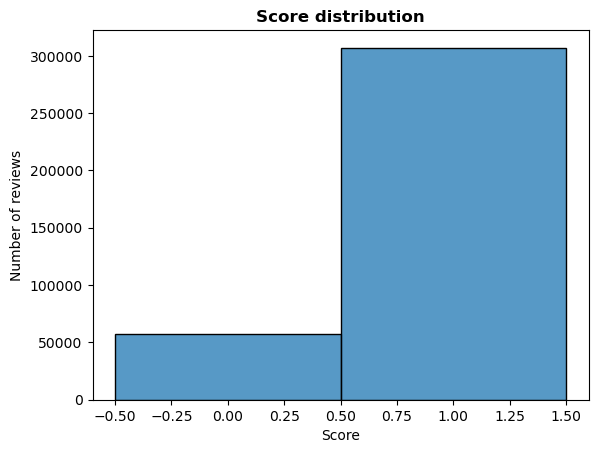

In [61]:
sns.histplot(df_binary['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [64]:
sample_size_binary = df_binary.groupby('Score').count().min()[0]
sample_size_binary

57108

In [65]:
binary_downsampled = df_binary.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size_binary))
binary_downsampled

,Score,Lemmatized Text
141497,0,"[maybe, personal, taste, tried, close, sense, ..."
79108,0,"[looking, forward, lovely, whole, wheat, looki..."
379533,0,"[allergic, corn, starch, though, anne, chin, p..."
90730,0,"[user, starbucks, sugarfree, syrupy, year, pri..."
341622,0,"[read, nodule, diet, magazine, intrigue, first..."
...,...,...
373396,1,"[bought, reading, review, im, happy, much, bet..."
28538,1,"[home, grew, beat, starbucks, organic, one, lo..."
286154,1,"[really, like, maggie, beef, bullion, granule,..."
359264,1,"[mate, de, cock, cock, tea, used, century, ind..."


In [67]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_downsampled["Lemmatized Text"], 
                                                    binary_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=binary_downsampled['Score'])

### BOW

In [68]:
cv_bin = CountVectorizer(min_df=0., max_df=1.0)
cv_model_bin = cv_bin.fit(X_train_bin.astype(str)) 
X_train_BOW_bin = cv_model_bin.transform(X_train_bin.astype(str))

In [69]:
tSVD_BOW_bin = TruncatedSVD(n_components = 1000)
SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)
X_train_BOW_bin = tSVD_BOW_bin.transform(X_train_BOW_bin)
print(SVD_BOW_bin.explained_variance_ratio_.sum())

0.7921237321620768


In [70]:
X_test_BOW_bin = cv_model_bin.transform(X_test_bin.astype(str))
X_test_BOW_bin = SVD_BOW_bin.transform(X_test_BOW_bin)

In [71]:
# Regressione

lr_BOW_bin = LogisticRegression(random_state=1)
model_lr_BOW_bin = lr_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_lr_BOW_bin = model_lr_BOW_bin.predict(X_test_BOW_bin)

In [72]:
# Random Forest

rf_BOW_bin = RandomForestClassifier(n_jobs = -1)
model_rf_BOW_bin = rf_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_rf_BOW_bin = model_rf_BOW_bin.predict(X_test_BOW_bin)

Performance:

In [73]:
evaluation(predictions_lr_BOW_bin, y_test_bin)

[[14755  2377]
 [ 2266 14867]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     17132
           1       0.86      0.87      0.86     17133

    accuracy                           0.86     34265
   macro avg       0.86      0.86      0.86     34265
weighted avg       0.86      0.86      0.86     34265



In [74]:
evaluation(predictions_rf_BOW_bin, y_test_bin)

[[13897  3235]
 [ 5597 11536]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76     17132
           1       0.78      0.67      0.72     17133

    accuracy                           0.74     34265
   macro avg       0.75      0.74      0.74     34265
weighted avg       0.75      0.74      0.74     34265



### TF-IDF

In [75]:
tv_bin = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_bin = tv_bin.fit(X_train_bin.astype(str))
X_train_TFIDF_bin = tv_bin.transform(X_train_bin.astype(str))

In [76]:
tSVD_TFIDF_bin = TruncatedSVD(n_components = 1000)
SVD_TFIDF_bin = tSVD_TFIDF_bin.fit(X_train_TFIDF_bin)
X_train_TFIDF_bin = tSVD_TFIDF_bin.transform(X_train_TFIDF_bin)
print(SVD_TFIDF_bin.explained_variance_ratio_.sum())

0.5657663291337944


In [77]:
X_test_TFIDF_bin = tv_model_bin.transform(X_test_bin.astype(str))
X_test_TFIDF_bin = SVD_TFIDF_bin.transform(X_test_TFIDF_bin)

In [78]:
# Regressione

lr_TFIDF_bin = LogisticRegression(random_state=1)
model_lr_TFIDF_bin = lr_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_lr_TFIDF_bin = model_lr_TFIDF_bin.predict(X_test_TFIDF_bin)

In [79]:
# Random Forest

rf_TFIDF_bin = RandomForestClassifier(n_jobs = -1)
model_rf_TFIDF_bin = rf_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_rf_TFIDF_bin = model_rf_TFIDF_bin.predict(X_test_TFIDF_bin)

Performance:

In [82]:
evaluation(predictions_lr_TFIDF_bin, y_test_bin)

[[14953  2179]
 [ 2267 14866]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     17132
           1       0.87      0.87      0.87     17133

    accuracy                           0.87     34265
   macro avg       0.87      0.87      0.87     34265
weighted avg       0.87      0.87      0.87     34265



In [83]:
evaluation(predictions_rf_TFIDF_bin, y_test_bin)

[[13583  3549]
 [ 3945 13188]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     17132
           1       0.79      0.77      0.78     17133

    accuracy                           0.78     34265
   macro avg       0.78      0.78      0.78     34265
weighted avg       0.78      0.78      0.78     34265



### W2V

In [84]:
w2v_model_bin = gensim.models.Word2Vec(X_train_bin, vector_size=300, window=8, min_count=2)

In [85]:
words_bin = set(w2v_model_bin.wv.index_to_key) 

X_train_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_train_bin])
X_test_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_test_bin])

In [86]:
X_train_bin_vect_avg = []
for v in X_train_bin_vect:
    if v.size:
        X_train_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_train_bin_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_bin_vect_avg = []
for v in X_test_bin_vect:
    if v.size:
        X_test_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_test_bin_vect_avg.append(np.zeros(300, dtype=float))

In [87]:
# Regressione logistica

lr_bin_W2V = LogisticRegression(random_state=1)
model_lr_bin_W2V = lr_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_lr_bin_W2V = model_lr_bin_W2V.predict(X_test_bin_vect_avg)

In [88]:
# Random Forest

rf_bin_W2V = RandomForestClassifier(n_jobs = -1)
model_rf_bin_W2V = rf_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_rf_bin_W2V = model_rf_bin_W2V.predict(X_test_bin_vect_avg)

Performance:

In [89]:
evaluation(predictions_lr_bin_W2V, y_test_bin)

[[14743  2389]
 [ 2536 14597]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     17132
           1       0.86      0.85      0.86     17133

    accuracy                           0.86     34265
   macro avg       0.86      0.86      0.86     34265
weighted avg       0.86      0.86      0.86     34265



In [90]:
evaluation(predictions_rf_bin_W2V, y_test_bin)

[[14491  2641]
 [ 2811 14322]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     17132
           1       0.84      0.84      0.84     17133

    accuracy                           0.84     34265
   macro avg       0.84      0.84      0.84     34265
weighted avg       0.84      0.84      0.84     34265



## Idee successive

- Usare altri altri modelli (SVM, KNN, ...)
- Valutare considerazioni su downsampling
- Ottimizzazione iperparametri (specialmente su W2V, usare skipgram/cbow, e ottimizzare finestra, ecc...)
- BERT (?)